<a href="https://colab.research.google.com/github/zahrahrp/property-price-pred/blob/master/Property_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import library

In [ ]:
!pip install geopandas folium==0.12.1 matplotlib mapclassify pyproj rtree geojson pygeos
!pip install --index-url https://test.pypi.org/simple/ -U julearn --pre
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as scp
import joblib
sns.set()

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from julearn.model_selection import StratifiedGroupsKFold

import math
import time
from shapely.geometry import Point
import geopandas as gpd 
from geopandas import GeoDataFrame 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.4 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 6.3 MB 51.8 MB/s 
     |████████████████████████████████| 1.0 MB 44.3 MB/s 
     |████████████████████████████████| 2.1 MB 40.8 MB/s 
     |████████████████████████████████| 16.7 MB 41.8 MB/s 
  Attempting uninstall: folium
    Found existing installation: folium 0.12.1.post1
    Uninstalling folium-0.12.1.post1:
      Successfully uninstalled folium-0.12.1.post1
Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


## Helper Function

In [ ]:
# Helper function to view std statistics
# If isReturn == True, function will return dictionary containing stats
# If isReturn == False, function will print statistics
def std_stats(df, column, isReturn):
    mean = np.mean(df[column], axis=0)
    sd = np.std(df[column], axis=0)
    
    upper_3_dist, lower_3_dist = mean + 3 * sd, mean - 3 * sd
    upper_2_dist, lower_2_dist = mean + 2 * sd, mean - 2 * sd
    upper_1_dist, lower_1_dist = mean + 1 * sd, mean - 1 * sd
    context = {
        'mean' : mean,
        'upper_3_dist' : upper_3_dist,
        'lower_3_dist' : lower_3_dist,
        'upper_2_dist' : upper_2_dist,
        'lower_2_dist' : lower_2_dist,
        'upper_1_dist' : upper_1_dist,
        'lower_1_dist' : lower_1_dist,
    }
    if isReturn:
        return context
    else :
        print('Std Statistics')
        for key in context:
            print(key, ' : ', context[key])

In [ ]:
# Helper function to view iqr statistics
# If isReturn == True, function will return dictionary containing stats
# If isReturn == False, function will print statistics
def iqr_stats(df, column, isReturn):
    minimum = min(df[column])
    maximum = max(df[column])
    q1 = np.quantile(df[column], 0.25)
    q2 = np.quantile(df[column], 0.5)
    q3 = np.quantile(df[column], 0.75)
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    context = {
        'q1' : q1,
        'q2' : q2,
        'q3' : q3,
        'iqr' : iqr,
        'upper' : upper,
        'lower' : lower,
    }
    if isReturn:
        return context
    else :
        print('Iqr Statistics')
        for key in context:
            print(key, ' : ', context[key])

In [ ]:
def create_kde_plot(df, column, type):
    plt.figure(figsize=(12,10))
    sns.kdeplot(df[column], shade=True)
    stats = {}
    if type=='std':
        stats = std_stats(df, column, True)
    elif type == 'iqr':
        stats = iqr_stats(df, column, True)
    list_color = ['blue', 'brown', 'red', 'black', 'yellow', 'grey', 'green', 'chocolate']
    for key in stats:
        label = str(key) + ': ' + str(stats[key])
        plt.axvline(x=stats[key], color=list_color.pop(), linestyle='--', label=label)
    
    plt.legend(loc=0)
    plt.show()

In [ ]:
def create_kde_plot_by_std(df, column, n_std):
    stats = std_stats(df, column, True)
    plt.figure(figsize=(12,10))
    sns.kdeplot(df[column], shade=True)
    upper = 'upper_' + str(n_std) + '_dist'
    lower = 'lower_' + str(n_std) + '_dist'
    list_color = ['orange', 'green', 'yellow', 'black', 'red', 'blue', 'brown', 'chocolate']
    for key in stats:
        if key==upper or key==lower :
            label = str(key) + ': ' + str(stats[key])
            plt.axvline(x=stats[key], color=list_color.pop(), linestyle='--', label=label)
    plt.axvline(x=stats['mean'], color=list_color.pop(), linestyle='--', label='Mean: '+ str(stats['mean']))
    plt.axvline(x=np.median(df[column]), color=list_color.pop(), linestyle='--', label='Median: ' + str(np.median(df[column])))
    plt.legend(loc=0)
    plt.show()

In [ ]:
# Helper function to create kde plot
def create_kde_plot2(df, column):
  plt.figure(figsize=(12,10))
  sns.kdeplot(df[column], shade=True)
  plt.axvline(x=np.mean(df[column]), color='blue', linestyle='--')
  plt.axvline(x=np.median(df[column]), color='brown', linestyle='--')
  plt.axvline(x=scp.mode(df[column])[0][0], color='red', linestyle='--')
  plt.axvline(x=np.quantile(df[column], 0.25), color='black', linestyle='--')
  plt.axvline(x=np.quantile(df[column], 0.75), color='yellow', linestyle='--')
  plt.legend([column, 'Mean', 'Median', 'Mode','Q1','Q3'], fontsize=12)
  plt.show()
  print("Mean: ", np.mean(df[column]))
  print("Mode: ", scp.mode(df[column]))
  print("Q1: ", np.quantile(df[column], 0.25 ))
  print("Median: ", np.median(df[column]))
  print("Q3: ", np.quantile(df[column], 0.75 ))

In [ ]:
# Helper function to check missing values
def cek_null(df):
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = col_na / len(df)
    
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data[missing_data['Total'] > 0])

In [ ]:
# Helper functin to check outlier
def check_outliers(df):
  mean = np.mean(df, axis=0)
  sd = np.std(df, axis=0)
  
  print("Total outliers: ")
  print(((df < (mean - 2 * sd)) | (df > (mean + 2 * sd))).sum())
  print()
  print("Persentase outliers: ")
  print(((df < (mean - 2 * sd)) | (df > (mean + 2 * sd))).sum() / len(df)*100)
  print()
  print("Average Outlier in Left Tail")
  print(np.mean(df[df < (mean - 2 * sd)]))
  print()
  print("Average Outlier in Right Tail")
  print(np.mean(df[df > (mean + 2 * sd)]))

In [ ]:
# Helper function to delete outlier
def delete_outlier_by_std(dataframe, column, n_std):
  mean = np.mean(dataframe[column], axis=0)
  sd = np.std(dataframe[column], axis=0)
  return dataframe[~((dataframe[column] <= (mean - n_std*sd)) |(dataframe[column] >= (mean + n_std*sd)))]

In [ ]:
# Helper function to check accuracy
def check_accuracy(y_test, y_pred):
    print("Statistical Evaluation")
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2S :', '{0:.2%}'.format(metrics.r2_score(y_test, y_pred)))

In [ ]:
def create_prediction_df_string(y_actual, y_pred):
    pred_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    pred = pred_df['Predicted']
    actual = pred_df['Actual']
    pred_df['Actual'] = pred_df.apply(lambda x: "{:,.4f}".format(x['Actual']), axis=1)
    pred_df['Predicted'] = pred_df.apply(lambda x: "{:,.4f}".format(x['Predicted']), axis=1)
    pred_df['Error'] = pred-actual
    pred_df['Error'] = pred_df.apply(lambda x: "{:,.4f}".format(x['Error']), axis=1)
    pred_df['pe'] = (pred-actual)/actual
    pred_df['ape'] = abs((pred-actual)/actual)
    return pred_df

In [ ]:
def create_prediction_df(y_actual, y_pred):
    pred_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    pred = pred_df['Predicted']
    actual = pred_df['Actual']
    pred_df['Error'] = pred-actual
    pred_df['pe'] = (pred-actual)/actual
    pred_df['ape'] = abs((pred-actual)/actual)
    return pred_df

In [ ]:
def evaluate_avm(pred_df):
    fsd = np.std(pred_df['pe'])/np.mean(pred_df['pe']) # std(pred_df['pe])
    pe10 = len(pred_df[pred_df['ape'] < 0.1])/len(pred_df)
    mape = np.median(pred_df['ape']) 
    rt20 = len(pred_df[pred_df['ape'] > 0.2])/len(pred_df)

    print("AVM Evaluation")
    print('fsd: ', '{0:.2%}'.format(fsd))
    print('pe10: ', '{0:.2%}'.format(pe10))
    print('mape: ', '{0:.2%}'.format(mape))
    print('rt20: ', '{0:.2%}'.format(rt20))

## Load Data

In [ ]:
# Read training dataset
df = pd.read_csv('/content/Jateng Jogja 04072022.csv') # local
print("Data has size:", df.shape)
df.head()

Data has size: (2711, 21)


,No.,ID,Y,X,Kelurahan,Kecamatan,Kota/Kabupaten,data,Tahun,Luas,...,posisi,topografi,jalan,penggunaan,zona,kelas,jarak,kota,pusat,hpm
0,1,64427,-7.045453,110.579898,Pundenarum,Karangawen,Kabupaten Demak,0,2022,2882.0,...,2,1,1,3,2,1,33.606762,18373.732393,18373.732393,2600000.0
1,2,64417,-7.030259,110.535616,Kembangarum,Mranggen,Kabupaten Demak,0,2022,5000.0,...,2,1,1,3,2,1,11.402547,13202.772329,13202.772329,4000000.0
2,3,64396,-7.022514,110.503360,Bandungrejo,Mranggen,Kabupaten Demak,0,2022,300.0,...,2,1,1,2,2,1,13.029769,9566.589904,9566.589904,10500000.0
3,4,64376,-7.159984,111.510838,Ngraho,Kedungtuban,Kabupaten Blora,1,2022,3600.0,...,2,1,1,3,2,0,7624.333339,61395.034397,121594.441516,550000.0
4,5,64375,-7.168413,111.503150,Ngraho,Kedungtuban,Kabupaten Blora,0,2022,700.0,...,2,1,1,3,1,0,8862.089524,60203.471543,120902.790104,1200000.0


## Data Preprocessing

In [ ]:
# View dataframe columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0    No.            2711 non-null   int64  
 1   ID              2711 non-null   int64  
 2   Y               2711 non-null   float64
 3   X               2711 non-null   float64
 4   Kelurahan       2711 non-null   object 
 5   Kecamatan       2711 non-null   object 
 6   Kota/Kabupaten  2711 non-null   object 
 7   data            2711 non-null   int64  
 8   Tahun           2711 non-null   int64  
 9   Luas            2711 non-null   float64
 10  hak             2711 non-null   int64  
 11  posisi          2711 non-null   int64  
 12  topografi       2711 non-null   int64  
 13  jalan           2711 non-null   int64  
 14  penggunaan      2711 non-null   int64  
 15  zona            2711 non-null   int64  
 16  kelas           2711 non-null   int64  
 17  jarak           2711 non-null   f

In [ ]:
# Statistics atribut numerik
df.describe()

,No.,ID,Y,X,data,Tahun,Luas,hak,posisi,topografi,jalan,penggunaan,zona,kelas,jarak,kota,pusat,hpm
count,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2.711000e+03,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2.711000e+03
mean,1356.000000,34939.113242,-7.450401,110.340883,0.041682,2020.535965,6.773150e+03,0.938030,2.079307,0.952047,0.902988,2.122464,1.470675,0.329768,1395.127865,14765.511367,42933.353530,4.055932e+06
std,782.742614,18196.631137,0.353370,0.544595,0.199898,1.176687,7.883923e+04,0.241145,0.443048,0.213706,0.296029,0.959194,0.988013,0.470215,2490.931464,13480.503156,45922.449583,5.757530e+06
min,1.000000,341.000000,-8.136479,108.686174,0.000000,2016.000000,1.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269218,155.206823,378.815319,5.089286e+04
25%,678.500000,19774.000000,-7.753667,110.307395,0.000000,2020.000000,4.080000e+02,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,46.010403,5083.033949,6654.070179,9.000000e+05
50%,1356.000000,32912.000000,-7.564247,110.405085,0.000000,2021.000000,9.970000e+02,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,538.860656,9796.774729,23335.532145,2.125000e+06
75%,2033.500000,46475.500000,-7.058241,110.630000,0.000000,2021.000000,2.327000e+03,1.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1422.091283,20429.203741,60636.401849,4.500000e+06
max,2711.000000,64427.000000,-6.448402,111.605728,1.000000,2022.000000,2.000000e+06,1.000000,3.000000,1.000000,1.000000,3.000000,3.000000,1.000000,19297.106929,72038.659935,191195.765734,5.000000e+07


If the median is lower then the mean, you have major outliers in the high end of the distribution, and if the mean is lower then median you have major outliers in the low end.

In [ ]:
# Statistics atribut non-numerik
df.describe(include=object)

,Kelurahan,Kecamatan,Kota/Kabupaten
count,2711,2711,2711
unique,864,316,40
top,-,-,Kota Semarang
freq,190,190,441


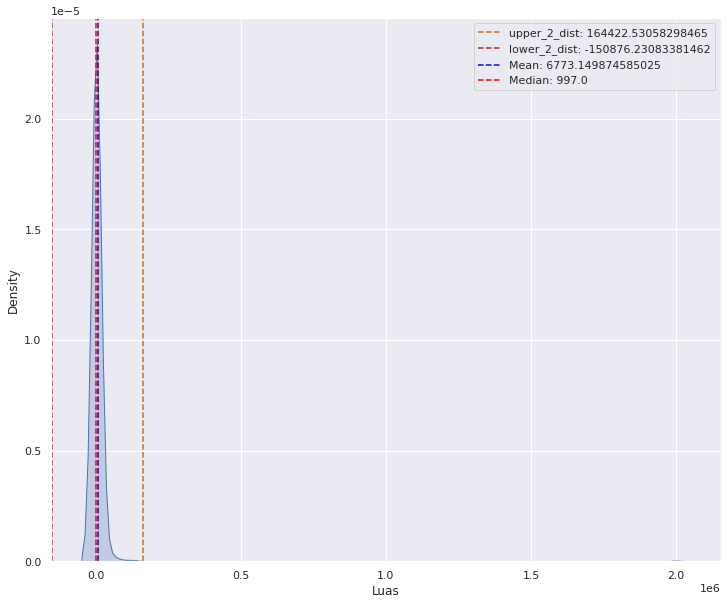

In [ ]:
create_kde_plot_by_std(df, 'Luas', 2)

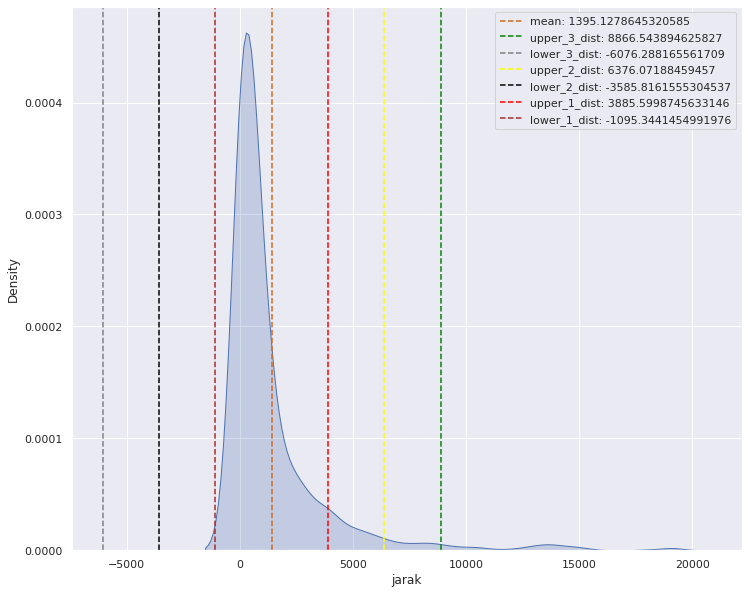

In [ ]:
create_kde_plot(df, 'jarak', 'std')

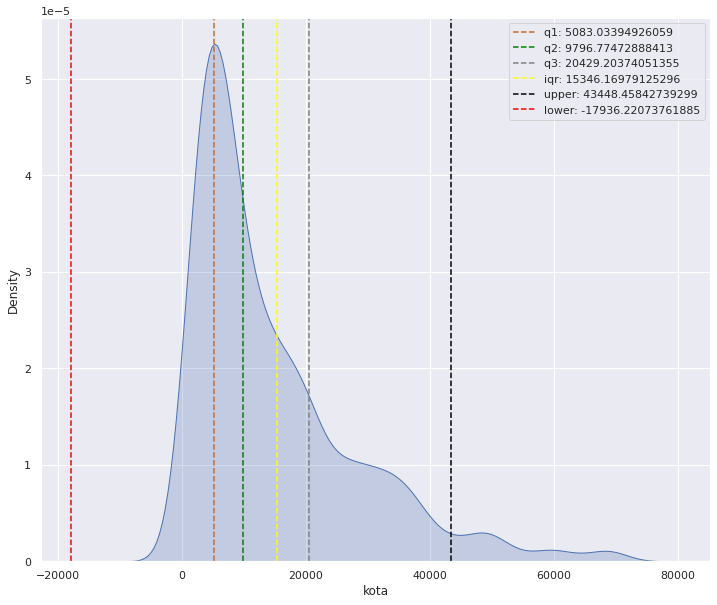

In [ ]:
create_kde_plot(df, 'kota', 'iqr')

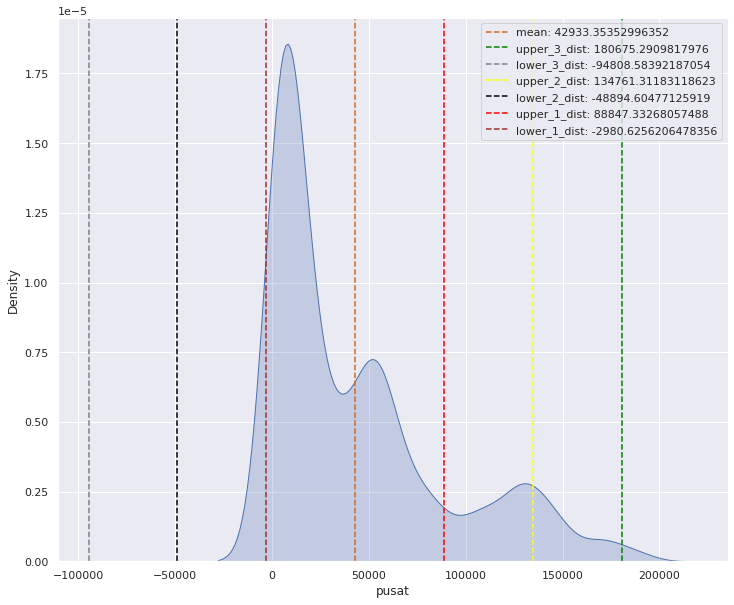

In [ ]:
create_kde_plot(df, 'pusat', 'std')

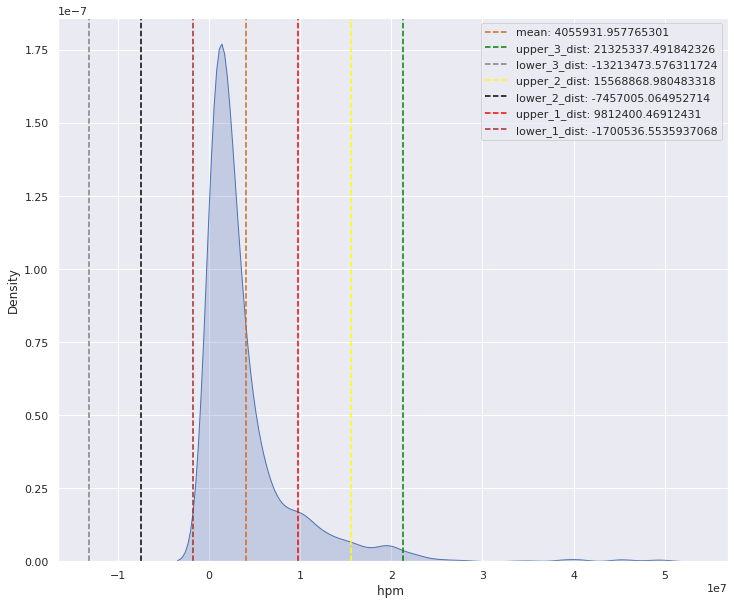

In [ ]:
create_kde_plot(df, 'hpm ', 'std')

#### Cek Duplikat

In [ ]:
df.duplicated(keep=False).sum()

0

In [ ]:
# Drop duplicate rows
no_duplicate_df = df.drop_duplicates()
no_duplicate_df.shape

(2711, 21)

#### Cek Missing Values

In [ ]:
cek_null(no_duplicate_df)

Empty DataFrame
Columns: [Total, Percent]
Index: []


In [ ]:
no_missing_val_df = no_duplicate_df.dropna()

#### Cek Outlier

In [ ]:
check_outliers(no_missing_val_df)

Total outliers: 
 No.                0
ID                  0
Kecamatan           0
Kelurahan           0
Kota/Kabupaten      0
Luas                6
Tahun             147
X                 279
Y                  81
data              113
hak               168
hpm               131
jalan             263
jarak             115
kelas               0
kota              139
penggunaan        322
posisi            498
pusat             174
topografi         130
zona                0
dtype: int64

Persentase outliers: 
 No.               0.000000
ID                 0.000000
Kecamatan          0.000000
Kelurahan          0.000000
Kota/Kabupaten     0.000000
Luas               0.221321
Tahun              5.422353
X                 10.291405
Y                  2.987827
data               4.168204
hak                6.196975
hpm                4.832165
jalan              9.701217
jarak              4.241977
kelas              0.000000
kota               5.127259
penggunaan        11.877536
posisi   

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  import sys
/usr/local/

In [ ]:
# Check skewness of data distribution
no_missing_val_df.skew(axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


 No.           0.000000
ID             0.380923
Y              0.553281
X             -0.929285
data           4.588894
Tahun         -0.518045
Luas          24.151789
hak           -3.635601
posisi        -0.063325
topografi     -4.233680
jalan         -2.724635
penggunaan    -1.054891
zona           0.553616
kelas          0.724596
jarak          3.613644
kota           1.544159
pusat          1.240107
hpm            3.591400
dtype: float64

In [ ]:
no_missing_val_df.describe()

,No.,ID,Y,X,data,Tahun,Luas,hak,posisi,topografi,jalan,penggunaan,zona,kelas,jarak,kota,pusat,hpm
count,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2.711000e+03,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2711.000000,2.711000e+03
mean,1356.000000,34939.113242,-7.450401,110.340883,0.041682,2020.535965,6.773150e+03,0.938030,2.079307,0.952047,0.902988,2.122464,1.470675,0.329768,1395.127865,14765.511367,42933.353530,4.055932e+06
std,782.742614,18196.631137,0.353370,0.544595,0.199898,1.176687,7.883923e+04,0.241145,0.443048,0.213706,0.296029,0.959194,0.988013,0.470215,2490.931464,13480.503156,45922.449583,5.757530e+06
min,1.000000,341.000000,-8.136479,108.686174,0.000000,2016.000000,1.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269218,155.206823,378.815319,5.089286e+04
25%,678.500000,19774.000000,-7.753667,110.307395,0.000000,2020.000000,4.080000e+02,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,46.010403,5083.033949,6654.070179,9.000000e+05
50%,1356.000000,32912.000000,-7.564247,110.405085,0.000000,2021.000000,9.970000e+02,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,538.860656,9796.774729,23335.532145,2.125000e+06
75%,2033.500000,46475.500000,-7.058241,110.630000,0.000000,2021.000000,2.327000e+03,1.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1422.091283,20429.203741,60636.401849,4.500000e+06
max,2711.000000,64427.000000,-6.448402,111.605728,1.000000,2022.000000,2.000000e+06,1.000000,3.000000,1.000000,1.000000,3.000000,3.000000,1.000000,19297.106929,72038.659935,191195.765734,5.000000e+07


In [ ]:
# Remove outlier from luas, jarak, kota, pusat, hpm
no_outlier_df = delete_outlier_by_std(no_missing_val_df, 'Luas', 2)

In [ ]:
no_outlier_df.describe()

,No.,ID,Y,X,data,Tahun,Luas,hak,posisi,topografi,jalan,penggunaan,zona,kelas,jarak,kota,pusat,hpm
count,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2.705000e+03
mean,1356.853235,34938.567098,-7.451817,110.340672,0.041774,2020.535305,3412.942444,0.939741,2.079482,0.951941,0.903142,2.124954,1.470240,0.330499,1393.950779,14716.584155,42762.176925,4.064190e+06
std,783.331034,18214.272075,0.352455,0.542408,0.200110,1.177777,10468.020829,0.238010,0.443523,0.213931,0.295819,0.958025,0.988816,0.470480,2492.315576,13431.199004,45764.896360,5.761239e+06
min,1.000000,341.000000,-8.136479,108.686174,0.000000,2016.000000,101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269218,155.206823,378.815319,5.089286e+04
25%,677.000000,19769.000000,-7.754213,110.307402,0.000000,2020.000000,406.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,45.733292,5069.851125,6635.844795,9.000000e+05
50%,1358.000000,32902.000000,-7.565449,110.405085,0.000000,2021.000000,987.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,537.065636,9776.351338,23295.718104,2.125000e+06
75%,2035.000000,46484.000000,-7.063595,110.628409,0.000000,2022.000000,2300.000000,1.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1419.240580,20346.265058,60190.609342,4.500000e+06
max,2711.000000,64427.000000,-6.448402,111.605728,1.000000,2022.000000,150000.000000,1.000000,3.000000,1.000000,1.000000,3.000000,3.000000,1.000000,19297.106929,72038.659935,191195.765734,5.000000e+07


In [ ]:
check_outliers(no_outlier_df)

Total outliers: 
 No.                0
ID                  0
Kecamatan           0
Kelurahan           0
Kota/Kabupaten      0
Luas               70
Tahun             147
X                 276
Y                  78
data              113
hak               163
hpm               130
jalan             262
jarak             115
kelas               0
kota              138
penggunaan        320
posisi            498
pusat             175
topografi         130
zona                0
dtype: int64

Persentase outliers: 
 No.               0.000000
ID                 0.000000
Kecamatan          0.000000
Kelurahan          0.000000
Kota/Kabupaten     0.000000
Luas               2.587800
Tahun              5.434381
X                 10.203327
Y                  2.883549
data               4.177449
hak                6.025878
hpm                4.805915
jalan              9.685767
jarak              4.251386
kelas              0.000000
kota               5.101664
penggunaan        11.829945
posisi   

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  import sys
/usr/local/

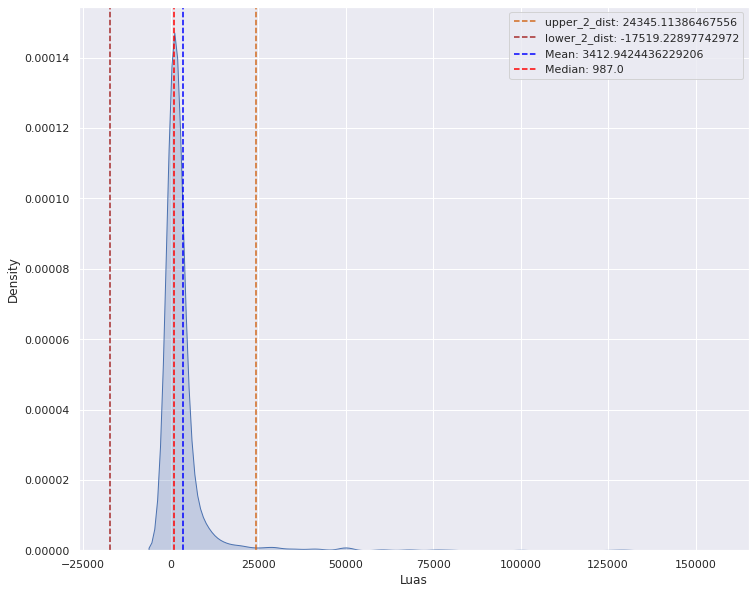

In [ ]:
create_kde_plot_by_std(no_outlier_df, 'Luas', 2)

In [ ]:
# Cari jumlah outlier yang > 20000
len(no_outlier_df[no_outlier_df['Luas'] > 20000])

79

In [ ]:
# Remove baris dengan luas >= 20000 
no_outlier2_df = no_outlier_df[no_outlier_df['Luas'] < 20000]
no_outlier2_df

,No.,ID,Y,X,Kelurahan,Kecamatan,Kota/Kabupaten,data,Tahun,Luas,...,posisi,topografi,jalan,penggunaan,zona,kelas,jarak,kota,pusat,hpm
0,1,64427,-7.045453,110.579898,Pundenarum,Karangawen,Kabupaten Demak,0,2022,2882.0,...,2,1,1,3,2,1,33.606762,18373.732393,18373.732393,2.600000e+06
1,2,64417,-7.030259,110.535616,Kembangarum,Mranggen,Kabupaten Demak,0,2022,5000.0,...,2,1,1,3,2,1,11.402547,13202.772329,13202.772329,4.000000e+06
2,3,64396,-7.022514,110.503360,Bandungrejo,Mranggen,Kabupaten Demak,0,2022,300.0,...,2,1,1,2,2,1,13.029769,9566.589904,9566.589904,1.050000e+07
3,4,64376,-7.159984,111.510838,Ngraho,Kedungtuban,Kabupaten Blora,1,2022,3600.0,...,2,1,1,3,2,0,7624.333339,61395.034397,121594.441516,5.500000e+05
4,5,64375,-7.168413,111.503150,Ngraho,Kedungtuban,Kabupaten Blora,0,2022,700.0,...,2,1,1,3,1,0,8862.089524,60203.471543,120902.790104,1.200000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,2707,8355,-7.826678,110.305612,-,-,0,0,2020,115.0,...,2,1,1,2,1,0,2102.392431,6879.382558,6879.382558,1.260000e+06
2707,2708,8354,-7.825238,110.310832,-,-,Kabupaten Bantul,0,2020,105.0,...,3,1,1,2,1,0,1505.262364,6284.352173,6284.352173,1.285714e+06
2708,2709,8340,-7.834986,110.307402,-,-,Kabupaten Bantul,0,2019,128.0,...,2,1,1,2,1,0,2354.799103,7071.220095,7071.220095,1.328125e+06
2709,2710,8338,-7.823707,110.310580,-,-,Kabupaten Bantul,0,2020,101.0,...,3,1,1,2,1,0,1494.359464,6253.255387,6253.255387,1.350000e+06


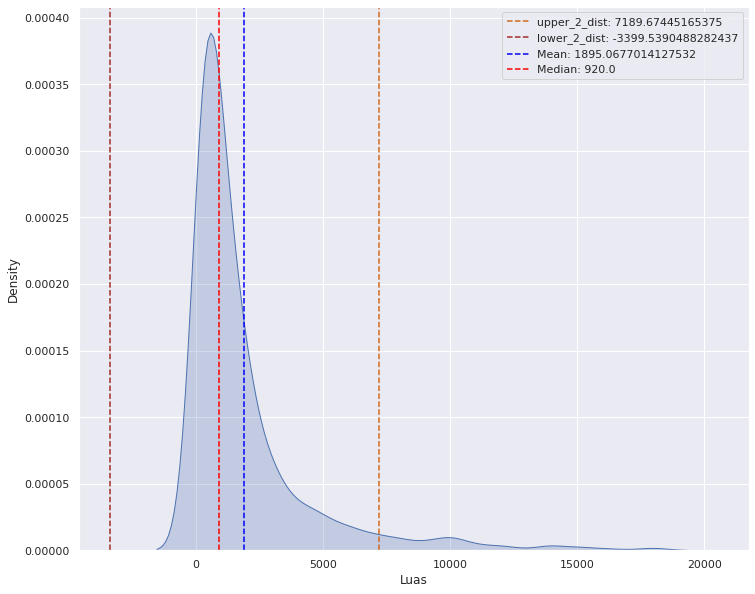

In [ ]:
create_kde_plot_by_std(no_outlier2_df, 'Luas', 2)

In [ ]:
no_outlier2_df.describe()

,No.,ID,Y,X,data,Tahun,Luas,hak,posisi,topografi,jalan,penggunaan,zona,kelas,jarak,kota,pusat,hpm
count,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2.619000e+03
mean,1363.945781,34874.908744,-7.458776,110.341556,0.042764,2020.536082,1895.067701,0.942344,2.081711,0.955326,0.903016,2.137839,1.476518,0.329133,1387.630156,14525.255333,42402.160947,4.147803e+06
std,787.536240,18255.199383,0.349237,0.539882,0.202364,1.173840,2647.808923,0.233136,0.445036,0.206626,0.295992,0.947281,0.990271,0.469988,2505.682248,13365.705068,45689.284273,5.810184e+06
min,1.000000,341.000000,-8.136479,108.686174,0.000000,2016.000000,101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269218,155.206823,378.815319,5.089286e+04
25%,675.500000,19695.500000,-7.756589,110.313250,0.000000,2020.000000,400.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,46.387476,4948.054206,6502.693757,9.490385e+05
50%,1377.000000,32754.000000,-7.570173,110.405965,0.000000,2021.000000,920.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,533.555472,9471.995092,22217.674646,2.177083e+06
75%,2050.500000,46492.000000,-7.075750,110.627246,0.000000,2022.000000,2059.000000,1.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1388.871529,20079.336726,59787.401392,4.685547e+06
max,2711.000000,64427.000000,-6.448402,111.605728,1.000000,2022.000000,18896.000000,1.000000,3.000000,1.000000,1.000000,3.000000,3.000000,1.000000,19297.106929,72038.659935,191195.765734,5.000000e+07


In [ ]:
df_clean = no_outlier2_df

#### Cek Variance

In [ ]:
df_clean.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


 No.          6.202133e+05
ID            3.332523e+08
Y             1.219666e-01
X             2.914728e-01
data          4.095126e-02
Tahun         1.377899e+00
Luas          7.010892e+06
hak           5.435218e-02
posisi        1.980573e-01
topografi     4.269412e-02
jalan         8.761122e-02
penggunaan    8.973415e-01
zona          9.806363e-01
kelas         2.208889e-01
jarak         6.278444e+06
kota          1.786421e+08
pusat         2.087511e+09
hpm           3.375823e+13
dtype: float64

In [ ]:
# Make stratified group from Kota/Kabupaten
stratified_groups = list(df_clean['Kota/Kabupaten'].astype('category').cat.codes)

In [ ]:
df_clean = no_outlier2_df

## Modelling

In [ ]:
# Split dataframe into X and Y
list_columns_deleted = [' No.', 'ID', 'Y','X','Kelurahan','Kecamatan','hpm ', 'Kota/Kabupaten']
X = df_clean.drop(list_columns_deleted, axis=1) # feature
Y = df_clean['hpm '] # target

In [ ]:
Y_ln = np.log(Y)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2619 entries, 0 to 2710
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data        2619 non-null   int64  
 1   Tahun       2619 non-null   int64  
 2   Luas        2619 non-null   float64
 3   hak         2619 non-null   int64  
 4   posisi      2619 non-null   int64  
 5   topografi   2619 non-null   int64  
 6   jalan       2619 non-null   int64  
 7   penggunaan  2619 non-null   int64  
 8   zona        2619 non-null   int64  
 9   kelas       2619 non-null   int64  
 10  jarak       2619 non-null   float64
 11  kota        2619 non-null   float64
 12  pusat       2619 non-null   float64
dtypes: float64(4), int64(9)
memory usage: 286.5 KB


In [ ]:
X.describe()

,data,Tahun,Luas,hak,posisi,topografi,jalan,penggunaan,zona,kelas,jarak,kota,pusat
count,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000,2619.000000
mean,0.042764,2020.536082,1895.067701,0.942344,2.081711,0.955326,0.903016,2.137839,1.476518,0.329133,1387.630156,14525.255333,42402.160947
std,0.202364,1.173840,2647.808923,0.233136,0.445036,0.206626,0.295992,0.947281,0.990271,0.469988,2505.682248,13365.705068,45689.284273
min,0.000000,2016.000000,101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269218,155.206823,378.815319
25%,0.000000,2020.000000,400.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,46.387476,4948.054206,6502.693757
50%,0.000000,2021.000000,920.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,533.555472,9471.995092,22217.674646
75%,0.000000,2022.000000,2059.000000,1.000000,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,1388.871529,20079.336726,59787.401392
max,1.000000,2022.000000,18896.000000,1.000000,3.000000,1.000000,1.000000,3.000000,3.000000,1.000000,19297.106929,72038.659935,191195.765734


### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score

kf = KFold(n_splits = 10,shuffle = True)
res = []
for train_index, test_index in kf.split(X,Y_ln):
      # Split data into training and testing sets
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = Y_ln.iloc[train_index], Y_ln.iloc[test_index] 
      cv_inner = KFold(n_splits=3, shuffle=True)
      rf = RandomForestRegressor()
      param_grid = {
          'max_depth': [10, 25, 50],
          'n_estimators': [10, 50, 100, 150]
      }
      # scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
      grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='neg_mean_squared_error', cv = 5)
      result = grid_search.fit(X_train, y_train)
      best_model = result.best_estimator_
      y_pred = best_model.predict(X_test)
      res.append(result.best_score_)
      print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
print('MSE: %.3f (%.3f)' % (np.mean(res), np.std(res)))


est=-0.507, cfg={'max_depth': 10, 'n_estimators': 150}
est=-0.515, cfg={'max_depth': 10, 'n_estimators': 100}
est=-0.501, cfg={'max_depth': 10, 'n_estimators': 150}
est=-0.499, cfg={'max_depth': 50, 'n_estimators': 150}
est=-0.505, cfg={'max_depth': 25, 'n_estimators': 100}
est=-0.508, cfg={'max_depth': 50, 'n_estimators': 100}
est=-0.504, cfg={'max_depth': 50, 'n_estimators': 150}
est=-0.516, cfg={'max_depth': 10, 'n_estimators': 150}
est=-0.508, cfg={'max_depth': 10, 'n_estimators': 150}
est=-0.513, cfg={'max_depth': 10, 'n_estimators': 150}
MSE: -0.508 (0.005)


### Training Data

#### Random Forest Regression

In [ ]:
# Initialize value
pred_df = df
counter = 0
best_score = 0
best_model = RandomForestRegressor()

# Stratified Group K Fold
skf = StratifiedGroupsKFold(n_splits=10,shuffle=True)

for train_index, test_index in skf.split(X,Y_ln, groups=list(df_clean['penggunaan'])):
    counter+=1
    print("FOLD: ", counter)
    
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y_ln.iloc[train_index], Y_ln.iloc[test_index] 
        
    # Testing data
    model = RandomForestRegressor(max_depth=10, n_estimators=150, max_features='sqrt', bootstrap=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
        
    # Evaluate prediction
    pred_df = create_prediction_df(y_test, y_pred)
    score = metrics.mean_squared_error(y_test, y_pred)
    check_accuracy(y_test, y_pred)
    evaluate_avm(pred_df)
    
    if counter == 1:
        best_score = score
        best_model = model
        
    else:
        if score < best_score:
            best_score = score
            best_model = model
    
    print()

FOLD:  1
Statistical Evaluation
MAE: 0.45272560545863233
MSE: 0.33235601759947775
RMSE: 0.5765032676398961
R2S : 77.15%
AVM Evaluation
fsd:  1870.68%
pe10:  96.95%
mape:  2.66%
rt20:  0.00%

FOLD:  2
Statistical Evaluation
MAE: 0.44618029030785294
MSE: 0.3180545469313689
RMSE: 0.5639632496283503
R2S : 78.70%
AVM Evaluation
fsd:  -3051.48%
pe10:  97.71%
mape:  2.62%
rt20:  0.00%

FOLD:  3
Statistical Evaluation
MAE: 0.44114795804310303
MSE: 0.3114948198374897
RMSE: 0.558117209766452
R2S : 77.96%
AVM Evaluation
fsd:  754.54%
pe10:  97.71%
mape:  2.47%
rt20:  0.00%

FOLD:  4
Statistical Evaluation
MAE: 0.4653726989565226
MSE: 0.34352548453705267
RMSE: 0.586110471274019
R2S : 77.41%
AVM Evaluation
fsd:  1081.97%
pe10:  97.71%
mape:  2.60%
rt20:  0.00%

FOLD:  5
Statistical Evaluation
MAE: 0.4492615206307937
MSE: 0.34076928514509097
RMSE: 0.5837544733405398
R2S : 76.52%
AVM Evaluation
fsd:  1455.79%
pe10:  98.09%
mape:  2.52%
rt20:  0.00%

FOLD:  6
Statistical Evaluation
MAE: 0.502304567506

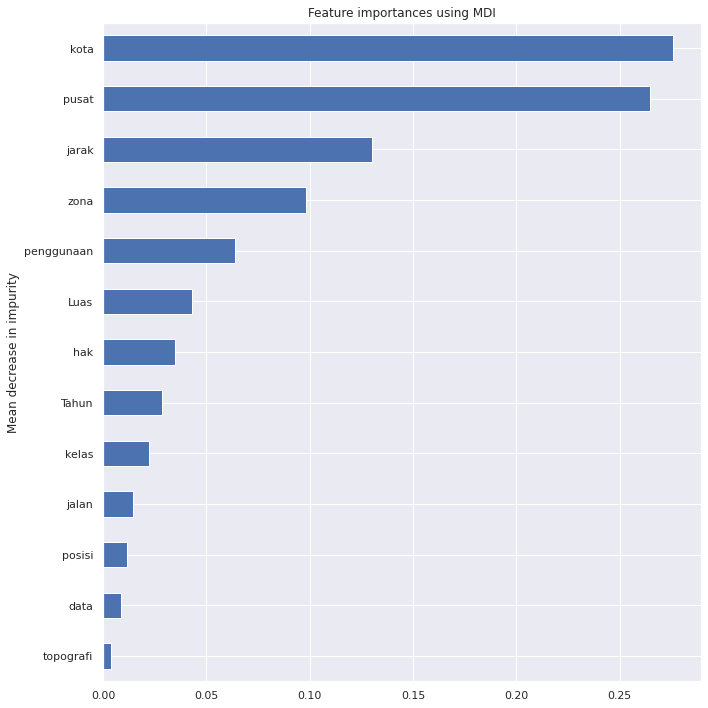

In [ ]:
# Feature Importances
feature_names = list(X.columns.values)
forest_importances = pd.Series(model.feature_importances_, X.columns).sort_values(ascending = False)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Predict data

In [ ]:
# Split dataframe into X and Y
list_columns_deleted = [' No.', 'ID', 'Y','X','Kelurahan','Kecamatan','hpm ', 'Kota/Kabupaten']
X_df = df.drop(list_columns_deleted, axis=1) # feature
Y_df = np.log(df['hpm ']) # target

In [ ]:
# Selected model
model

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=150)

In [ ]:
# Predict data
y_pred = model.predict(X_df) # using selected param

#### Evaluation

In [ ]:
pred_df = create_prediction_df(Y_df, y_pred)
pred_df

,Actual,Predicted,Error,pe,ape
0,14.771022,14.590909,-0.180113,-0.012194,0.012194
1,15.201805,14.587928,-0.613877,-0.040382,0.040382
2,16.166886,15.132526,-1.034360,-0.063980,0.063980
3,13.217674,13.165053,-0.052620,-0.003981,0.003981
4,13.997832,13.586939,-0.410893,-0.029354,0.029354
...,...,...,...,...,...
2706,14.046622,14.560477,0.513855,0.036582,0.036582
2707,14.066825,14.706597,0.639772,0.045481,0.045481
2708,14.099279,14.530134,0.430855,0.030559,0.030559
2709,14.115615,14.701982,0.586367,0.041540,0.041540


In [ ]:
check_accuracy(Y_df, y_pred)

Statistical Evaluation
MAE: 0.36354821619014704
MSE: 0.21477375424799458
RMSE: 0.46343689349035927
R2S : 86.20%


In [ ]:
evaluate_avm(pred_df)

AVM Evaluation
fsd:  1394.09%
pe10:  98.86%
mape:  2.11%
rt20:  0.00%


In [ ]:
# Combine two dataframe
pred_combine = pd.concat([df, pred_df], axis=1)

In [ ]:
pred_combine

,No.,ID,Y,X,Kelurahan,Kecamatan,Kota/Kabupaten,data,Tahun,Luas,...,kelas,jarak,kota,pusat,hpm,Actual,Predicted,Error,pe,ape
0,1,64427,-7.045453,110.579898,Pundenarum,Karangawen,Kabupaten Demak,0,2022,2882.0,...,1,33.606762,18373.732393,18373.732393,2.600000e+06,14.771022,14.590909,-0.180113,-0.012194,0.012194
1,2,64417,-7.030259,110.535616,Kembangarum,Mranggen,Kabupaten Demak,0,2022,5000.0,...,1,11.402547,13202.772329,13202.772329,4.000000e+06,15.201805,14.587928,-0.613877,-0.040382,0.040382
2,3,64396,-7.022514,110.503360,Bandungrejo,Mranggen,Kabupaten Demak,0,2022,300.0,...,1,13.029769,9566.589904,9566.589904,1.050000e+07,16.166886,15.132526,-1.034360,-0.063980,0.063980
3,4,64376,-7.159984,111.510838,Ngraho,Kedungtuban,Kabupaten Blora,1,2022,3600.0,...,0,7624.333339,61395.034397,121594.441516,5.500000e+05,13.217674,13.165053,-0.052620,-0.003981,0.003981
4,5,64375,-7.168413,111.503150,Ngraho,Kedungtuban,Kabupaten Blora,0,2022,700.0,...,0,8862.089524,60203.471543,120902.790104,1.200000e+06,13.997832,13.586939,-0.410893,-0.029354,0.029354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,2707,8355,-7.826678,110.305612,-,-,0,0,2020,115.0,...,0,2102.392431,6879.382558,6879.382558,1.260000e+06,14.046622,14.560477,0.513855,0.036582,0.036582
2707,2708,8354,-7.825238,110.310832,-,-,Kabupaten Bantul,0,2020,105.0,...,0,1505.262364,6284.352173,6284.352173,1.285714e+06,14.066825,14.706597,0.639772,0.045481,0.045481
2708,2709,8340,-7.834986,110.307402,-,-,Kabupaten Bantul,0,2019,128.0,...,0,2354.799103,7071.220095,7071.220095,1.328125e+06,14.099279,14.530134,0.430855,0.030559,0.030559
2709,2710,8338,-7.823707,110.310580,-,-,Kabupaten Bantul,0,2020,101.0,...,0,1494.359464,6253.255387,6253.255387,1.350000e+06,14.115615,14.701982,0.586367,0.041540,0.041540


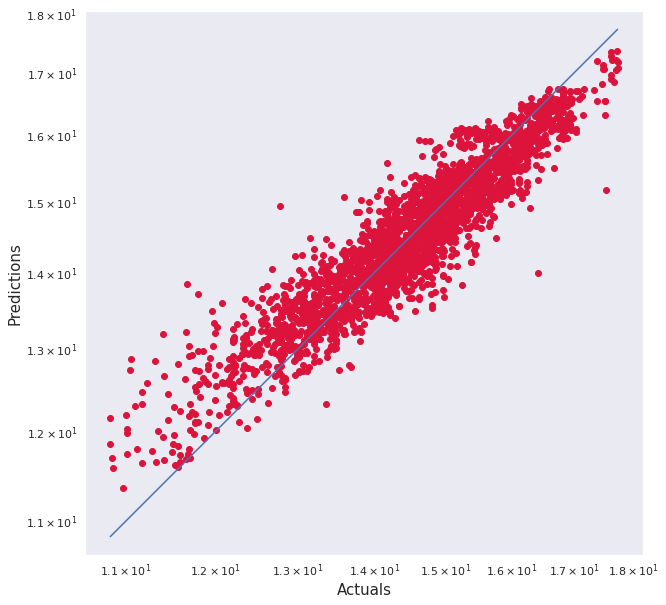

In [ ]:
# Scatter plot
plt.figure(figsize=(10,10))
plt.scatter(pred_df['Actual'], pred_df['Predicted'] , c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(pred_df['Predicted']), max(pred_df['Actual']))
p2 = min(min(pred_df['Predicted']), min(pred_df['Actual']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actuals', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Spatial

In [ ]:
geometry = df.apply(lambda x: Point((float(x['X']), float(x['Y']))), axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [ ]:
gdf = GeoDataFrame(pred_combine, geometry=geometry, crs={'init':'EPSG:4326'})   

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
gdf.explore(column='Predicted', k=10, scheme='quantiles', cmap='Reds')